In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
sns.set(font='Arial')

In [2]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.seasonal import STL
plt.rc("figure", figsize=(16, 10))

In [3]:
df = pd.read_csv('..\\data\\pareto\\acapricna_q.csv',index_col=0)
df=df.join(pd.read_csv('..\\data\\pareto\\acapricnr_q.csv',index_col=0))

df.index=df.index.rename('Date')
df.index=pd.DatetimeIndex(df.index,freq='QS-OCT')

In [5]:
nat_var = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='national',engine='openpyxl',index_col=0)
prov_var=pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='provincial',engine='openpyxl',index_col=0)
covid = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='covid_dummy',engine='openpyxl',index_col=0)
wti = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='wti',engine='openpyxl',index_col=0)


nat_var.index = nat_var.index.str.replace(' ','')
nat_var.index = nat_var.index.rename('Date')
nat_var.index = pd.PeriodIndex(nat_var.index,freq='Q').to_timestamp()

prov_var.index = prov_var.index.rename('Date')
prov_var.index = pd.PeriodIndex(prov_var.index,freq='Q').to_timestamp()


covid.index = covid.index.str.replace(' ','')
covid.index = covid.index.rename('Date')
covid.index = pd.PeriodIndex(covid.index,freq='Q').to_timestamp()

wti.index=wti.index.str.replace(' ','')
wti.index = wti.index.rename('Date')
wti.index = pd.PeriodIndex(wti.index,freq='Q').to_timestamp()

In [6]:
prov_var = prov_var.join(nat_var)
prov_var = prov_var.join(covid)
prov_var = prov_var.join(wti)

In [8]:
df = prov_var.join(df)

In [9]:
df

,gdp_AB_2023,gdp_AB_2023_alt,unemp_AB_2023,unemp_AB_2023_alt,emp_AB_2023,emp_AB_2023_alt,cpi_AB_2023,cpi_AB_2023_alt,cpiyoy_AB_2023,cpiyoy_AB_2023_alt,...,"Interest rate, 10-Year Benchmark Bond Yield",5_year_mortgage_base,5_year_mortgage_alt,COVID-19,Long COVID,WTI_base,WTI_lower,WTI_upper,ACAPRICNA_Q,ACAPRICNR_Q
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-01,124537.696000,124537.696000,10.900000,10.900000,1.131647e+03,1.131647e+03,59.343473,59.343473,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,89421.0
1984-04-01,126432.684000,126432.684000,11.600000,11.600000,1.132964e+03,1.132964e+03,59.518123,59.518123,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,90088.0
1984-07-01,124688.800000,124688.800000,11.733333,11.733333,1.140598e+03,1.140598e+03,60.048126,60.048126,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,88172.0
1984-10-01,128648.819000,128648.819000,11.400000,11.400000,1.143396e+03,1.143396e+03,60.322322,60.322322,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,78667.0
1985-01-01,134650.900000,134650.900000,10.466667,10.466667,1.161539e+03,1.161539e+03,60.899252,60.899252,0.026217,0.026217,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,78728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031-10-01,109352.714760,107851.494108,7.185151,7.319139,2.781406e+06,2.778234e+06,199.523198,203.938562,NaN,NaN,...,3.399802,5.354558,5.354917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-01-01,109928.705420,108427.224288,7.184067,7.311531,2.793558e+06,2.790639e+06,200.616464,205.099268,NaN,NaN,...,3.399804,5.354558,5.354913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032-04-01,110510.286436,109004.833763,7.182163,7.304960,2.806114e+06,2.803405e+06,201.715522,206.266343,NaN,NaN,...,3.399764,5.354547,5.355319,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
sel_res = ardl_select_order(df['ACAPRICNA_Q']['1996':'2022'],4,df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base','cpiyoy_AB_2023']]['1996':'2022'],ic='aic',trend='t',maxorder=12)

In [39]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACAPRICNA_Q   No. Observations:                  108
Model:               ARDL(4, 9, 4, 1)   Log Likelihood               -1058.250
Method:               Conditional MLE   S.D. of innovations           6352.106
Date:                Thu, 23 Feb 2023   AIC                           2162.500
Time:                        17:56:36   BIC                           2223.321
Sample:                    04-01-1998   HQIC                          2187.140
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
trend                     509.8224    167.899      3.036      0.003     175.818     843.827
ACAPRICNA_Q.L1              1.2483      0.099     12.667      0.000       1.052       1.444
ACAPRICNA_Q.L2             -0.3185      0.149     -2.133      0.036      -0.616      -0.021
ACAPRICNA_Q.L3              0.1960      0.139      1.411      0.162      -0.080       0.472
ACAPRICNA_Q.L4             -0.2618      0.093     -2.806      0.006      -0.447      -0.076
unemp_AB_2023.L0        -2311.7801   1093.148     -2.115      0.037   -4486.400    -137.160
unemp_AB_2023.L1         6438.4849   1375.099      4.682      0.000    3702.976    9173.994
unemp_AB_2023.L2        -4841.3761   1530.604     -3.163      0.002   -7886.236   -1796.516
unemp_AB_2023.L3         3344.2601   1571.003      2.129      0.036     219.035    6469.485
unemp_AB_2023.L4        -1659.5851   1527.106     -1.087      0.280   -4697.486    1378.316
unemp_AB_2023.L5        -2199.6372   1353.073     -1.626      0.108   -4891.330     492.056
unemp_AB_2023.L6         2549.2138   1354.515      1.882      0.063    -145.348    5243.776
unemp_AB_2023.L7         3333.4130   1372.583      2.429      0.017     602.907    6063.919
unemp_AB_2023.L8        -7830.4269   1463.201     -5.352      0.000   -1.07e+04   -4919.654
unemp_AB_2023.L9         2405.0812   1228.674      1.957      0.054     -39.143    4849.305
WTI_upper.L0              257.3981     89.819      2.866      0.005      78.719     436.077
WTI_upper.L1             -284.8053    137.331     -2.074      0.041    -558.000     -11.611
WTI_upper.L2               98.7892    141.907      0.696      0.488    -183.509     381.087
WTI_upper.L3             -137.7120    140.372     -0.981      0.329    -416.957     141.533
WTI_upper.L4              314.2627     97.578      3.221      0.002     120.149     508.376
5_year_mortgage_base.L0  9803.6176   3565.605      2.749      0.007    2710.494    1.69e+04
5_year_mortgage_base.L1 -7764.1982   3412.466     -2.275      0.026   -1.46e+04    -975.716
===========================================================================================
"""

<AxesSubplot:xlabel='Date'>

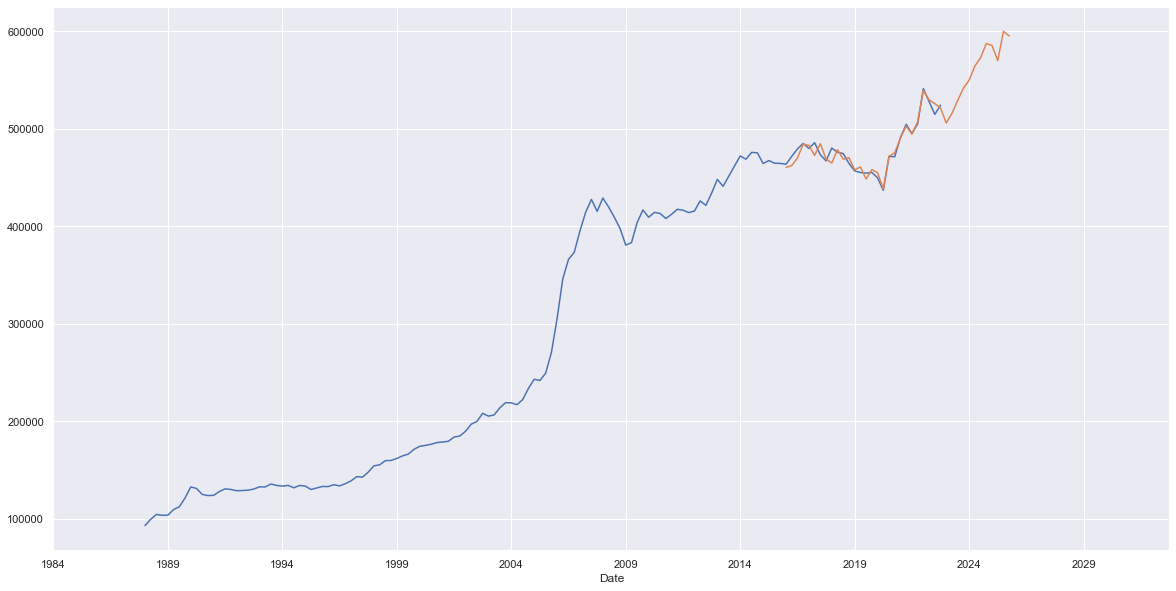

In [41]:
df['ACAPRICNA_Q'].plot(figsize=(20,10))

res.predict(start=80,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base','cpiyoy_AB_2023']]['2018':'2025']).plot()

In [61]:
res.predict(start=80,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base','cpiyoy_AB_2023']]['2018':'2025'])['2021':].resample('A').mean()

2021-12-31    498743.624992
2022-12-31    528991.927859
2023-12-31    523050.960313
2024-12-31    568525.288719
2025-12-31    587545.458366
Freq: A-DEC, dtype: float64

In [59]:
res.predict(start=80,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base','cpiyoy_AB_2023']]['2018':'2025'])['2021':].to_csv('price_fcast_23.csv')

In [56]:
predict = res.get_prediction(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base','cpiyoy_AB_2023']]['2016':'2025'])
predict_ci = predict.conf_int(alpha=0.6)

<AxesSubplot:xlabel='Date'>

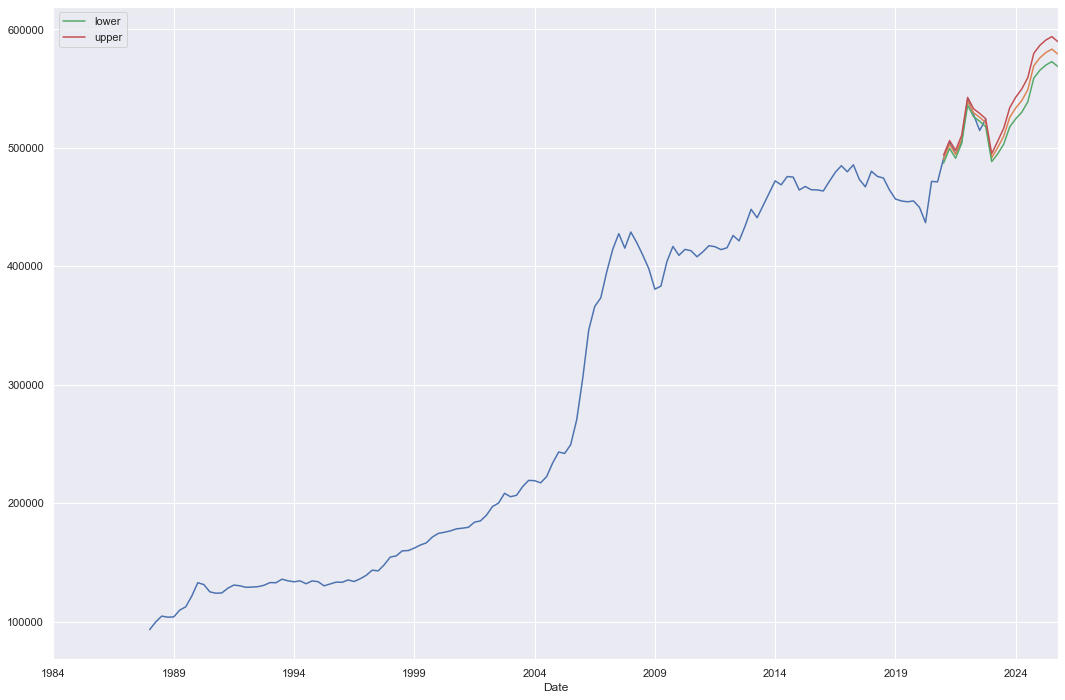

In [57]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

df['ACAPRICNA_Q'][:'2022'].plot(ax=ax)

predict.predicted_mean.plot(ax=ax)
predict_ci.plot(ax=ax)